# 🚀 OPTIMIZED REVENUE FORECASTING WITH ELASTICNET

## CRITICAL DOMAIN KNOWLEDGE:
1. **actual_revenue**: Revenue for ONE month only. Always use `shift(1)` - we don't have current month's actual.
2. **committed_signed/unsigned, wtd_pipeline**: CUMULATIVE M→Dec values (sum of remaining months). Always DECREASING.
3. **Units are DIFFERENT**: Cannot directly mix actual_revenue (1 month) with cumulative columns.
4. **avg_prob_pct**: Standalone feature - don't combine with other columns.

## KEY INSIGHT FOR DELTA FEATURES:
Since cumulative values are always decreasing, we can create:
- `committed_signed_m - committed_signed_m-1` = change in cumulative (shows how much was added/removed)
- These delta features capture the MONTHLY contribution to the forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

pd.set_option('display.float_format', lambda x: f'{x:.2f}')
print('✅ Libraries imported!')

✅ Libraries imported!


In [2]:
# Load data
df = pd.read_csv('mon_final.csv', index_col=0)
df = df.sort_values(['year', 'month_num']).reset_index(drop=True)
print(f'Dataset shape: {df.shape}')
print(f'Years: {sorted(df["year"].unique())}')
print(f'Columns: {list(df.columns)}')

Dataset shape: (33, 9)
Years: [np.int64(2023), np.int64(2024), np.int64(2025)]
Columns: ['year', 'month', 'month_num', 'actual_revenue', 'wtd_pipeline_revenue', 'committed_unsig_revenue', 'committed_sign_revenue', 'avg_prob_pct', 'date']


In [111]:
def create_comprehensive_features(df):
    """
    Create comprehensive domain-specific features following strict business rules.

    CRITICAL RULES:
    1. actual_revenue: Always shift(1) - we don't have current month's actual
    2. committed_signed/unsigned, wtd_pipeline: Cumulative M→Dec, normalize by remaining_months
    3. DELTA FEATURES: committed_m - committed_m-1 captures monthly change in forecast
    4. avg_prob_pct: Standalone feature
    """
    df_feat = df.copy().sort_values(['year', 'month_num']).reset_index(drop=True)
    print('\n' + '='*80)
    print('COMPREHENSIVE FEATURE ENGINEERING')
    print('='*80)

    # ========== TIER 1: TIME CONTEXT ==========
    print('\n TIER 1: Time Context Features')
    df_feat['remaining_months'] = 13 - df_feat['month_num']  # Jan=12, Dec=1
    df_feat['year_progress'] = (df_feat['month_num'] - 1) / 11  # 0 to 1 scale
    df_feat['quarter'] = ((df_feat['month_num'] - 1) // 3) + 1
    df_feat['quarter_progress'] = ((df_feat['month_num'] - 1) % 3) / 2  # 0, 0.5, 1
    df_feat['time_pressure'] = 1 / (df_feat['remaining_months'] + 0.5)  # Higher as year ends
    df_feat['quarter_intensity'] = df_feat['quarter'].map({1: 0.85, 2: 0.95, 3: 1.0, 4: 1.15})
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month_num'] / 12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month_num'] / 12)
    df_feat['is_quarter_end'] = df_feat['month_num'].isin([3, 6, 9, 12]).astype(int)
    print(f'  Created 9 time context features')

    # ========== TIER 2: DENSITY METRICS (Normalize cumulative by remaining months) ==========
    print('\n TIER 2: Density Metrics (Scale-Invariant)')
    df_feat['signed_density'] = df_feat['committed_sign_revenue'] / df_feat['remaining_months']
    df_feat['unsigned_density'] = df_feat['committed_unsig_revenue'] / df_feat['remaining_months']
    df_feat['pipeline_density'] = df_feat['wtd_pipeline_revenue'] / df_feat['remaining_months']
    df_feat['total_committed'] = df_feat['committed_sign_revenue'] + df_feat['committed_unsig_revenue']
    df_feat['total_committed_density'] = df_feat['total_committed'] / df_feat['remaining_months']
    df_feat['total_forecast'] = df_feat['total_committed'] + df_feat['wtd_pipeline_revenue']
    df_feat['total_forecast_density'] = df_feat['total_forecast'] / df_feat['remaining_months']
    print(f'  Created 7 density features')

    # ========== TIER 3: DELTA FEATURES (KEY INNOVATION) ==========
    print('\n TIER 3: Delta Features (Monthly Changes in Cumulative)')
    # These capture how much the cumulative forecast changed from month to month
    # Negative delta = some deals closed/removed, Positive delta = new deals added

    # Delta from M to M-1 (1-month change)
    df_feat['signed_delta_1m'] = df_feat['committed_sign_revenue'].diff(1)
    df_feat['unsigned_delta_1m'] = df_feat['committed_unsig_revenue'].diff(1)
    df_feat['pipeline_delta_1m'] = df_feat['wtd_pipeline_revenue'].diff(1)
    df_feat['total_forecast_delta_1m'] = df_feat['signed_delta_1m']+df_feat['unsigned_delta_1m']+df_feat['pipeline_delta_1m']#df_feat['total_forecast'].diff(1)

    # Delta from M to M-2 (2-month change)
    df_feat['signed_delta_2m'] = df_feat['committed_sign_revenue'].diff(2)
    df_feat['unsigned_delta_2m'] = df_feat['committed_unsig_revenue'].diff(2)
    df_feat['pipeline_delta_2m'] = df_feat['wtd_pipeline_revenue'].diff(2)

    # Delta from M to M-3 (3-month/quarter change)
    df_feat['signed_delta_3m'] = df_feat['committed_sign_revenue'].diff(3)
    df_feat['pipeline_delta_3m'] = df_feat['wtd_pipeline_revenue'].diff(3)

    # Delta density (change per remaining month)
    df_feat['signed_density_delta_1m'] = df_feat['signed_density'].diff(1)
    df_feat['pipeline_density_delta_1m'] = df_feat['pipeline_density'].diff(1)

    # Acceleration of deltas (2nd derivative)
    df_feat['signed_delta_acceleration'] = df_feat['signed_delta_1m'].diff(1)
    df_feat['pipeline_delta_acceleration'] = df_feat['pipeline_delta_1m'].diff(1)
    print(f'  Created 13 delta features')

    ####################
    df_feat['signed_delta_acceleration_3m'] = df_feat['signed_delta_1m'].diff(3)
    df_feat['pipeline_delta_acceleration_3m'] = df_feat['pipeline_delta_1m'].diff(3)
    df_feat['total_forecast_delta_acceleration'] = df_feat['total_forecast_delta_1m'].diff(1)


      ###################

    # ========== TIER 4: RATIO FEATURES (Scale-Invariant) ==========
    print('\n TIER 4: Ratio Features')
    df_feat['signed_to_total_ratio'] = df_feat['committed_sign_revenue'] / (df_feat['total_committed'] + 1e-10)
    df_feat['signed_to_forecast_ratio'] = df_feat['committed_sign_revenue'] / (df_feat['total_forecast'] + 1e-10)
    df_feat['pipeline_to_committed_ratio'] = df_feat['wtd_pipeline_revenue'] / (df_feat['total_committed'] + 1e-10)
    df_feat['unsigned_to_signed_ratio'] = df_feat['committed_unsig_revenue'] / (df_feat['committed_sign_revenue'] + 1e-10)
    df_feat['signed_density_to_forecast_density'] = df_feat['signed_density'] / (df_feat['total_forecast_density'] + 1e-10)
    print(f'  Created 5 ratio features')

    # ========== TIER 5: LAGGED REVENUE (CRITICAL: always shift(1)+) ==========
    print('\n TIER 5: Lagged Revenue Features (shift(1) for all)')
    for lag in [1, 2, 3, 6, 12]:
        df_feat[f'revenue_lag_{lag}'] = df_feat['actual_revenue'].shift(lag)

    # Lagged density features
    for lag in [1, 2, 3]:
        df_feat[f'signed_density_lag_{lag}'] = df_feat['signed_density'].shift(lag)
        df_feat[f'pipeline_density_lag_{lag}'] = df_feat['pipeline_density'].shift(lag)
    print(f'  Created 11 lagged features')

    # ========== TIER 6: ROLLING STATISTICS (Using shift(1) to avoid leakage) ==========
    print('\n TIER 6: Rolling Statistics')
    for window in [3, 6, 12]:
        df_feat[f'revenue_rolling_mean_{window}'] = df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).mean()
        df_feat[f'revenue_rolling_std_{window}'] = df_feat['actual_revenue'].shift(1).rolling(window=window, min_periods=1).std()

    for window in [3, 6]:
        df_feat[f'signed_density_rolling_mean_{window}'] = df_feat['signed_density'].rolling(window=window, min_periods=1).mean()
        df_feat[f'pipeline_density_rolling_mean_{window}'] = df_feat['pipeline_density'].rolling(window=window, min_periods=1).mean()
    print(f'  Created 10 rolling features')

    # ========== TIER 7: EWM FEATURES ==========
    print('\n TIER 7: EWM Features')
    for span in [3, 6, 12]:
        df_feat[f'revenue_ewm_{span}'] = df_feat['actual_revenue'].shift(1).ewm(span=span, min_periods=1).mean()

    df_feat['signed_density_ewm_6'] = df_feat['signed_density'].ewm(span=6, min_periods=1).mean()
    df_feat['pipeline_density_ewm_6'] = df_feat['pipeline_density'].ewm(span=6, min_periods=1).mean()
    df_feat['total_forecast_density_ewm_6'] = df_feat['total_forecast_density'].ewm(span=6, min_periods=1).mean()

    # EWM of deltas
    df_feat['signed_delta_ewm_6'] = df_feat['signed_delta_1m'].ewm(span=6, min_periods=1).mean()
    df_feat['pipeline_delta_ewm_6'] = df_feat['pipeline_delta_1m'].ewm(span=6, min_periods=1).mean()
    print(f'  Created 8 EWM features')

    # ========== TIER 8: GROWTH RATES ==========
    print('\n TIER 8: Growth Rate Features')
    df_feat['revenue_growth_1m'] = df_feat['actual_revenue'].shift(1).pct_change(1)
    df_feat['revenue_growth_3m'] = df_feat['actual_revenue'].shift(1).pct_change(3)
    df_feat['revenue_growth_12m'] = df_feat['actual_revenue'].shift(1).pct_change(12)

    df_feat['signed_density_growth_1m'] = df_feat['signed_density'].pct_change(1)
    df_feat['signed_density_growth_3m'] = df_feat['signed_density'].pct_change(3)
    df_feat['pipeline_density_growth_1m'] = df_feat['pipeline_density'].pct_change(1)

    # Delta growth rates
    df_feat['signed_delta_growth'] = df_feat['signed_delta_1m'].pct_change(1).replace([np.inf, -np.inf], np.nan)
    print(f'  Created 7 growth rate features')

    ###################
    # Normalized growth rates (arctanh transformation for bounded values)
    df_feat['signed_density_growth_normalized'] = np.arctanh(
    np.clip(df_feat['signed_density_growth_1m'], -0.99, 0.99)
        ).fillna(0)

    df_feat['pipeline_density_growth_normalized'] = np.arctanh(
         np.clip(df_feat['pipeline_density_growth_1m'], -0.99, 0.99)
         ).fillna(0)

    # Relative growth rates (compared to historical average)
    df_feat['signed_growth_vs_avg'] = (
    df_feat['signed_density_growth_1m'] -
    df_feat['signed_density_growth_1m'].rolling(12, min_periods=1).mean()
    )

    df_feat['pipeline_growth_vs_avg'] = (
    df_feat['pipeline_density_growth_1m'] -
    df_feat['pipeline_density_growth_1m'].rolling(12, min_periods=1).mean()
     )
    ##################

    # ========== TIER 9: YoY FEATURES ==========
    print('\n TIER 9: Year-over-Year Features')
    df_feat['same_month_revenue_ly'] = df_feat.groupby('month_num')['actual_revenue'].shift(1)

    # YoY changes in cumulative values
    df_feat['signed_density_yoy'] = df_feat['signed_density'] / (df_feat.groupby('month_num')['signed_density'].shift(1) + 1e-10)
    df_feat['pipeline_density_yoy'] = df_feat['pipeline_density'] / (df_feat.groupby('month_num')['pipeline_density'].shift(1) + 1e-10)
    df_feat['signed_density_yoy_growth'] = df_feat['signed_density_yoy'] - 1
    df_feat['pipeline_density_yoy_growth'] = df_feat['pipeline_density_yoy'] - 1

    # YoY delta comparison
    df_feat['signed_delta_yoy'] = df_feat['signed_delta_1m'] - df_feat.groupby('month_num')['signed_delta_1m'].shift(1)
    print(f'  Created 6 YoY features')

    ####
    # YoY momentum (rate of change in YoY growth)
    df_feat['signed_density_yoy_momentum'] = df_feat['signed_density_yoy_growth'].diff(1)
    df_feat['pipeline_density_yoy_momentum'] = df_feat['pipeline_density_yoy_growth'].diff(1)

     # YoY acceleration (2nd derivative)
    df_feat['signed_density_yoy_acceleration'] = df_feat['signed_density_yoy_growth'].diff(3)

    # Relative YoY position (percentile rank)
    for col in ['signed_density', 'pipeline_density']:
        df_feat[f'{col}_yoy_percentile'] = df_feat.groupby('month_num')[f'{col}_yoy'].transform(
            lambda x: x.rank(pct=True))
    ###########

    # ========== TIER 10: BUSINESS INTELLIGENCE METRICS ==========
    print('\n TIER 10: Business Intelligence Metrics')

    # Run rate analysis
    df_feat['historical_run_rate'] = df_feat['actual_revenue'].shift(1).rolling(window=3, min_periods=1).mean()
    df_feat['required_run_rate'] = df_feat['total_committed_density']  # What we need per month
    df_feat['run_rate_gap'] = df_feat['required_run_rate'] - df_feat['historical_run_rate']
    df_feat['run_rate_gap_pct'] = df_feat['run_rate_gap'] / (df_feat['historical_run_rate'] + 1e-10)

    # Forecast confidence
    df_feat['forecast_confidence'] = df_feat['avg_prob_pct'] / df_feat['avg_prob_pct'].rolling(12, min_periods=1).mean()

    # Revenue stability
    df_feat['revenue_stability'] = 1 / (1 + df_feat['revenue_rolling_std_6'] / (df_feat['revenue_rolling_mean_6'] + 1e-10))
    df_feat['revenue_predictability'] = 1 / (1 + df_feat['revenue_rolling_std_12'].fillna(0) / (df_feat['revenue_rolling_mean_12'] + 1e-10))

    # Conversion efficiency (historical)
    df_feat['conversion_efficiency'] = (df_feat['actual_revenue'].shift(1) / (df_feat['signed_density'].shift(1) + 1e-10)).rolling(6, min_periods=1).mean()
    print(f'  Created 8 business intelligence features')

    #################
    # Time pressure adjusted metrics
    df_feat['pressure_adjusted_signed'] = df_feat['signed_density'] * (1 + df_feat['time_pressure'])
    df_feat['pressure_adjusted_pipeline'] = df_feat['pipeline_density'] * (1 + df_feat['time_pressure'])

    # Quarter-end pressure multiplier
    df_feat['quarter_end_pressure'] = df_feat['is_quarter_end'] * df_feat['time_pressure']

    # Historical pressure performance
    df_feat['historical_pressure_performance'] = (
    df_feat.groupby(['month_num', 'quarter'])['actual_revenue'].transform('mean') *
    df_feat['time_pressure'])

    ##################

    # ========== TIER 11: INTERACTION FEATURES ==========
    print('\n TIER 11: Interaction Features')
    df_feat['pressure_x_signed_density'] = df_feat['time_pressure'] * df_feat['signed_density']
    df_feat['quarter_x_signed_density'] = df_feat['quarter_intensity'] * df_feat['signed_density']
    df_feat['seasonal_pressure'] = df_feat['month_sin'] * df_feat['time_pressure']
    df_feat['conversion_urgency'] = df_feat['signed_to_total_ratio'] * df_feat['remaining_months']

    # Delta interactions
    df_feat['delta_x_time_pressure'] = df_feat['signed_delta_1m'] * df_feat['time_pressure']
    df_feat['delta_x_quarter'] = df_feat['signed_delta_1m'] * df_feat['quarter_intensity']
    print(f'  Created 6 interaction features')

    # ========== TIER 12: MOMENTUM FEATURES ==========
    print('\n TIER 12: Momentum Features')
    df_feat['revenue_acceleration'] = df_feat['revenue_growth_1m'].diff(1)
    df_feat['momentum_strength'] = df_feat['revenue_growth_3m'].abs().fillna(0) * df_feat['signed_density_growth_3m'].abs().fillna(0)

    # Delta momentum
    df_feat['delta_momentum'] = df_feat['signed_delta_1m'].rolling(3, min_periods=1).mean()
    df_feat['delta_trend'] = df_feat['signed_delta_1m'].rolling(6, min_periods=1).mean() - df_feat['signed_delta_1m'].rolling(3, min_periods=1).mean()
    print(f'  Created 4 momentum features')


    #################
    # Trend-aligned interactions (ensuring positive relationship with revenue)
    df_feat['aligned_signed_momentum'] = (
    df_feat['signed_density'] *
    np.maximum(df_feat['signed_density_growth_1m'], 0) *
    df_feat['time_pressure']
      )

    df_feat['aligned_pipeline_momentum'] = (
    df_feat['pipeline_density'] *
    np.maximum(df_feat['pipeline_density_growth_1m'], 0) *
    df_feat['time_pressure']
     )

    # Direction-corrected interactions
    df_feat['corrected_delta_interaction'] = (
    np.abs(df_feat['signed_delta_1m']) *
    df_feat['signed_density_growth_1m'].apply(lambda x: 1 if x > 0 else -1) *
    df_feat['time_pressure']
     )
    #############

    # ========== TIER 13: COMPOSITE SCORES ==========
    print('\n TIER 13: Composite Scores')
    df_feat['business_health'] = (
        0.3 * df_feat['signed_to_total_ratio'] +
        0.3 * df_feat['revenue_stability'].fillna(0.5) +
        #0.2 * df_feat['forecast_confidence'].clip(0, 2).fillna(1) / 2 +
        0.2 * (1 - df_feat['time_pressure'].clip(0, 1))
    )

    # df_feat['forecast_reliability'] = (
    #     df_feat['signed_to_total_ratio'].rolling(3, min_periods=1).mean() *
    #     df_feat['forecast_confidence'].fillna(1)
    # )

    # Delta-based composite
    df_feat['delta_health'] = (
        0.5 * (df_feat['signed_delta_ewm_6'] / (df_feat['signed_delta_ewm_6'].abs().max() + 1e-10)).fillna(0) +
        0.5 * (df_feat['pipeline_delta_ewm_6'] / (df_feat['pipeline_delta_ewm_6'].abs().max() + 1e-10)).fillna(0)
    )
    print(f'  Created 3 composite features')

    # ========== TIER 14: NON-LINEAR TRANSFORMATIONS ==========
    print('\n TIER 14: Non-Linear Transformations')
    df_feat['log_signed_density'] = np.log1p(df_feat['signed_density'])
    df_feat['log_pipeline_density'] = np.log1p(df_feat['pipeline_density'])
    df_feat['log_revenue_lag_1'] = np.log1p(df_feat['revenue_lag_1'].fillna(0))
    df_feat['sqrt_signed_density'] = np.sqrt(df_feat['signed_density'])
    df_feat['sqrt_total_forecast_density'] = np.sqrt(df_feat['total_forecast_density'])

    # Squared terms for non-linearity
    df_feat['signed_density_squared'] = df_feat['signed_density'] ** 2
    df_feat['time_pressure_squared'] = df_feat['time_pressure'] ** 2
    print(f'  Created 7 non-linear features')

    ##########################
    df_feat['signed_density_power_0_75'] = np.power(df_feat['signed_density'].clip(lower=0.01), 0.75)
    df_feat['pipeline_density_power_0_8'] = np.power(df_feat['pipeline_density'].clip(lower=0.01), 0.8)

    # Exponential decay for time pressure (reducing excessive penalty)
    df_feat['time_pressure_exp_decay'] = np.exp(-df_feat['time_pressure'] * 0.5)
    df_feat['signed_density_exp_scaled'] = df_feat['signed_density'] * df_feat['time_pressure_exp_decay']

    # Logarithmic compression for large values
    df_feat['log1p_total_forecast'] = np.log1p(df_feat['total_forecast'])
    df_feat['log1p_total_committed'] = np.log1p(df_feat['total_committed'])

    # Sigmoid transformation for ratios (bounding between 0-1)
    df_feat['signed_to_total_sigmoid'] = 1 / (1 + np.exp(-df_feat['signed_to_total_ratio'] * 5))
    #########################

    # ========== CLEANUP ==========
    print('\n Cleanup: Handling infinities and NaNs')
    for col in df_feat.columns:
        if df_feat[col].dtype in [np.float64, np.int64, np.float32]:
            df_feat[col] = df_feat[col].replace([np.inf, -np.inf], np.nan)

    # Count new features
    new_cols = list(set(df_feat.columns) - set(df.columns))
    print(f'\n TOTAL: Created {len(new_cols)} new features')

    return df_feat, new_cols

df_features, created_features = create_comprehensive_features(df)


COMPREHENSIVE FEATURE ENGINEERING

 TIER 1: Time Context Features
  Created 9 time context features

 TIER 2: Density Metrics (Scale-Invariant)
  Created 7 density features

 TIER 3: Delta Features (Monthly Changes in Cumulative)
  Created 13 delta features

 TIER 4: Ratio Features
  Created 5 ratio features

 TIER 5: Lagged Revenue Features (shift(1) for all)
  Created 11 lagged features

 TIER 6: Rolling Statistics
  Created 10 rolling features

 TIER 7: EWM Features
  Created 8 EWM features

 TIER 8: Growth Rate Features
  Created 7 growth rate features

 TIER 9: Year-over-Year Features
  Created 6 YoY features

 TIER 10: Business Intelligence Metrics
  Created 8 business intelligence features

 TIER 11: Interaction Features
  Created 6 interaction features

 TIER 12: Momentum Features
  Created 4 momentum features

 TIER 13: Composite Scores
  Created 3 composite features

 TIER 14: Non-Linear Transformations
  Created 7 non-linear features

 Cleanup: Handling infinities and NaNs


In [157]:
# Feature Selection using ONLY Lasso/Ridge/ElasticNet (no RandomForest)
def select_top_features_linear_only(df, feature_cols, target_col='actual_revenue', n_features=30):
    """
    Select top features using ONLY linear model methods:
    1. Correlation with target
    2. Lasso feature importance
    3. Ridge feature importance
    4. ElasticNet feature importance
    """
    print('\n' + '='*80)
    print('FEATURE SELECTION (Linear Models Only)')
    print('='*80)

    # Prepare data (drop NaN rows for clean analysis)
    analysis_df = df[feature_cols + [target_col]].dropna()
    X = analysis_df[feature_cols]
    y = analysis_df[target_col]

    # Standardize for fair comparison
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 1. Correlation with target
    print('\n Computing correlations...')
    correlations = {}
    for i, col in enumerate(feature_cols):
        corr = np.corrcoef(X_scaled[:, i], y)[0, 1]
        correlations[col] = abs(corr) if not np.isnan(corr) else 0

    # 2. Lasso importance
    print(' Training Lasso model...')
    lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_importance = {col: abs(coef) for col, coef in zip(feature_cols, lasso.coef_)}

    # 3. Ridge importance
    print(' Training Ridge model...')
    ridge = Ridge(alpha=1.0, random_state=42)
    ridge.fit(X_scaled, y)
    ridge_importance = {col: abs(coef) for col, coef in zip(feature_cols, ridge.coef_)}

    # 4. ElasticNet importance
    print(' Training ElasticNet model...')
    enet = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
    enet.fit(X_scaled, y)
    enet_importance = {col: abs(coef) for col, coef in zip(feature_cols, enet.coef_)}

    # Normalize each method to 0-1 scale
    def normalize(d):
        if len(d) == 0:
            return d
        max_v, min_v = max(d.values()), min(d.values())
        if max_v == min_v:
            return {k: 0.5 for k in d}
        return {k: (v - min_v) / (max_v - min_v) for k, v in d.items()}

    corr_norm = normalize(correlations)
    lasso_norm = normalize(lasso_importance)
    ridge_norm = normalize(ridge_importance)
    enet_norm = normalize(enet_importance)

    # Ensemble score (weighted average)
    print(' Computing ensemble scores...')
    ensemble = {}
    for col in feature_cols:
        ensemble[col] = (
            0.25 * corr_norm.get(col, 0) +
            0.25 * lasso_norm.get(col, 0) +
            0.25 * ridge_norm.get(col, 0) +
            0.25 * enet_norm.get(col, 0)
        )

    # Sort by ensemble score
    sorted_features = sorted(ensemble.items(), key=lambda x: x[1], reverse=True)

    print(f'\n TOP {n_features} FEATURES:')
    print('-'*60)
    for i, (feat, score) in enumerate(sorted_features[:n_features], 1):
        print(f'  {i:2}. {feat:45} (score: {score:.4f})')

    selected = [f[0] for f in sorted_features[:n_features]]
    return selected, ensemble

# Remove potential leakage features (any that directly use actual_revenue without proper shift)
safe_features = [f for f in created_features if 'actual_revenue' not in f or 'lag' in f or 'rolling' in f or 'ewm' in f or 'growth' in f or 'same_month' in f]

# Select top features
top_20_features, feature_scores = select_top_features_linear_only(df_features, safe_features, n_features=10)

# Ensure avg_prob_pct is included (domain requirement)
if 'avg_prob_pct' not in top_20_features:
    top_20_features.append('avg_prob_pct')
    print(f'\n Added avg_prob_pct (domain requirement)')

feature_cols = top_20_features
print(f'\n Final feature set: {len(feature_cols)} features')


FEATURE SELECTION (Linear Models Only)

 Computing correlations...
 Training Lasso model...
 Training Ridge model...
 Training ElasticNet model...
 Computing ensemble scores...

 TOP 10 FEATURES:
------------------------------------------------------------
   1. revenue_lag_12                                (score: 0.6320)
   2. same_month_revenue_ly                         (score: 0.6318)
   3. quarter_progress                              (score: 0.5722)
   4. log_revenue_lag_1                             (score: 0.5532)
   5. revenue_growth_12m                            (score: 0.5481)
   6. revenue_predictability                        (score: 0.5175)
   7. revenue_rolling_std_12                        (score: 0.4742)
   8. revenue_ewm_12                                (score: 0.4304)
   9. revenue_lag_3                                 (score: 0.4262)
  10. revenue_rolling_mean_12                       (score: 0.4173)

 Added avg_prob_pct (domain requirement)

 Final feature set:

In [158]:
feature_cols=[item for item in feature_cols] #if item !='revenue_predictability']
feature_cols

['revenue_lag_12',
 'same_month_revenue_ly',
 'quarter_progress',
 'log_revenue_lag_1',
 'revenue_growth_12m',
 'revenue_predictability',
 'revenue_rolling_std_12',
 'revenue_ewm_12',
 'revenue_lag_3',
 'revenue_rolling_mean_12',
 'avg_prob_pct']

In [159]:
type(feature_cols)

list

In [160]:
# Prepare data with features
df_with_features = df_features[feature_cols + ['year', 'month', 'month_num', 'actual_revenue']].copy()

# Current position: March 2025 (we have actuals up to March)
current_year = 2025
current_month = 3  # March

print(f'Current position: {current_month}/{current_year}')
print(f'Will simulate: April-December {current_year}')
print(f'Historical data available: {len(df_with_features)} rows')

Current position: 3/2025
Will simulate: April-December 2025
Historical data available: 33 rows


In [161]:
def classify_feature_type(feature_name):
    """
    Classify feature as 'revenue_based' or 'ratio_density_based'

    Revenue-based: Features derived from actual_revenue (use forward-fill)
    Ratio/Density: Features that are ratios, densities, percentages (use EWM-6)
    """
    revenue_keywords = [
        'revenue_lag', 'revenue_rolling', 'revenue_ewm', 'revenue_growth',
        'same_month_revenue', 'log_revenue', 'run_rate', 'historical_run_rate'
    ]

    for keyword in revenue_keywords:
        if keyword in feature_name:
            return 'revenue_based'

    return 'ratio_density_based'


def simulate_future_months_smart(historical_df, months_to_simulate, feature_columns,
                                  target_month=3, target_year=2025):
    """
    Smart simulation with different strategies:
    - Revenue-based features: FORWARD FILL (last known value)
    - Ratio/density features: EWM(6) simulation

    This respects that revenue-based features shouldn't be "predicted" with EWM
    but rather carried forward as the last known value.
    """
    print('\n' + '='*80)
    print('SMART FEATURE SIMULATION FOR FUTURE MONTHS')
    print('='*80)

    # Classify features
    revenue_features = [f for f in feature_columns if classify_feature_type(f) == 'revenue_based']
    ratio_features = [f for f in feature_columns if classify_feature_type(f) == 'ratio_density_based']

    print(f'\nRevenue-based features ({len(revenue_features)}): Forward Fill')
    for f in revenue_features[:5]:
        print(f'  - {f}')
    if len(revenue_features) > 5:
        print(f'  ... and {len(revenue_features)-5} more')

    print(f'\nRatio/Density features ({len(ratio_features)}): EWM(6)')
    for f in ratio_features[:5]:
        print(f'  - {f}')
    if len(ratio_features) > 5:
        print(f'  ... and {len(ratio_features)-5} more')

    # Get data up to current month
    data_up_to_current = historical_df[
        (historical_df['year'] < target_year) |
        ((historical_df['year'] == target_year) & (historical_df['month_num'] <= target_month))
    ].copy().sort_values(['year', 'month_num']).reset_index(drop=True)

    simulated_months = []
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

    print(f'\n🔄 Simulating {months_to_simulate} months...')

    for i in range(1, months_to_simulate + 1):
        m = target_month + i
        y = target_year
        if m > 12:
            m = m - 12
            y = target_year + 1

        new_row = {
            'year': y,
            'month': month_names[m-1],
            'month_num': m
        }

        for feature in feature_columns:
            feature_values = data_up_to_current[feature].dropna().tail(6).values

            if len(feature_values) == 0:
                val = 0
            elif classify_feature_type(feature) == 'revenue_based':
                # FORWARD FILL: Use last known value
                val = feature_values[-1]
            else:
                # EWM(6) simulation for ratio/density features
                if len(feature_values) < 6:
                    val = np.mean(feature_values)
                else:
                    alpha = 2 / (6 + 1)  # EWM alpha for span=6
                    weights = np.array([(1 - alpha) ** (5 - j) for j in range(6)])
                    weights = weights / weights.sum()
                    val = np.sum(feature_values * weights)

                # Add small random variation (1-2%)
                variation = np.random.normal(0, abs(val) * 0.015)
                val = val + variation

            new_row[feature] = val

        simulated_months.append(new_row)
        # Append to running data for next iteration
        data_up_to_current = pd.concat([data_up_to_current, pd.DataFrame([new_row])], ignore_index=True)

    print(f'\n Simulated {len(simulated_months)} months (Apr-Dec {target_year})')

    return pd.DataFrame(simulated_months)


# Simulate future months
simulated_data = simulate_future_months_smart(
    df_with_features,
    months_to_simulate=9,  # Apr-Dec = 9 months
    feature_columns=feature_cols,
    target_month=current_month,
    target_year=current_year
)

print('\nSimulated data preview:')
print(simulated_data[['year', 'month', 'month_num'] + feature_cols[:3]].head())


SMART FEATURE SIMULATION FOR FUTURE MONTHS

Revenue-based features (8): Forward Fill
  - revenue_lag_12
  - same_month_revenue_ly
  - log_revenue_lag_1
  - revenue_growth_12m
  - revenue_rolling_std_12
  ... and 3 more

Ratio/Density features (3): EWM(6)
  - quarter_progress
  - revenue_predictability
  - avg_prob_pct

🔄 Simulating 9 months...

 Simulated 9 months (Apr-Dec 2025)

Simulated data preview:
   year month  month_num  revenue_lag_12  same_month_revenue_ly  \
0  2025   Apr          4    155459389.30           155459389.30   
1  2025   May          5    155459389.30           155459389.30   
2  2025   Jun          6    155459389.30           155459389.30   
3  2025   Jul          7    155459389.30           155459389.30   
4  2025   Aug          8    155459389.30           155459389.30   

   quarter_progress  
0              0.62  
1              0.63  
2              0.65  
3              0.63  
4              0.67  


In [162]:
# Prepare test data: ONLY April-December 2025 (NOT from January!)
print('\n' + '='*80)
print('PREPARING TEST DATA: April-December 2025 ONLY')
print('='*80)

# Get actual revenue values for Apr-Nov 2025 from original data (Dec may be NaN)
original_2025_future = df[(df['year'] == 2025) & (df['month_num'] > current_month)][['month_num', 'actual_revenue']].copy()
print(f'\nActual revenue data available for months: {list(original_2025_future["month_num"].values)}')

# Merge simulated features with actual revenue
test_data = simulated_data.merge(original_2025_future, on='month_num', how='left')
test_data = test_data.sort_values('month_num').reset_index(drop=True)

print(f'\nTest data shape: {test_data.shape}')
print(f'Test data months: {list(test_data["month"].values)}')
print('\nTest data preview:')
print(test_data[['year', 'month', 'month_num', 'actual_revenue']].to_string())


PREPARING TEST DATA: April-December 2025 ONLY

Actual revenue data available for months: [np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]

Test data shape: (9, 15)
Test data months: ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

Test data preview:
   year month  month_num  actual_revenue
0  2025   Apr          4    170681266.00
1  2025   May          5    172455903.80
2  2025   Jun          6    171322481.00
3  2025   Jul          7    178908145.60
4  2025   Aug          8    173445947.90
5  2025  Sept          9    177238137.10
6  2025   Oct         10    184324060.90
7  2025   Nov         11    175457714.90
8  2025   Dec         12             NaN


In [163]:
# Prepare training data: 2023 + 2024
print('\n' + '='*80)
print('PREPARING TRAINING DATA: 2023-2024')
print('='*80)

train_data = df_with_features[df_with_features['year'].isin([2023, 2024])].copy()
print(f'Training data shape: {train_data.shape}')
print(f'Training years: {sorted(train_data["year"].unique())}')

# Prepare X and y
X_train = train_data[feature_cols].copy()
y_train = train_data['actual_revenue'].copy()

X_test = test_data[feature_cols].copy()
y_test = test_data['actual_revenue'].copy()  # May have NaN for Dec

# Handle NaN values - fill with median from training
for col in feature_cols:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f'\nX_train shape: {X_train_scaled.shape}')
print(f'X_test shape: {X_test_scaled.shape}')
print(f'y_train NaN count: {y_train.isna().sum()}')
print(f'y_test NaN count: {y_test.isna().sum()}')


PREPARING TRAINING DATA: 2023-2024
Training data shape: (22, 15)
Training years: [np.int64(2023), np.int64(2024)]

X_train shape: (22, 11)
X_test shape: (9, 11)
y_train NaN count: 0
y_test NaN count: 1


In [164]:
# Train ElasticNet with GridSearchCV
print('\n' + '='*80)
print('TRAINING ELASTICNET WITH HYPERPARAMETER TUNING')
print('='*80)

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

base_model = ElasticNet(random_state=42, max_iter=20000)
tscv = TimeSeriesSplit(n_splits=3)

grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_scaled, y_train)

print(f'\n Best parameters: {grid_search.best_params_}')
print(f'Best CV score (neg MAE): {grid_search.best_score_:,.0f}')

model = grid_search.best_estimator_
print(f'\nModel coefficients:')
for feat, coef in sorted(zip(feature_cols, model.coef_), key=lambda x: abs(x[1]), reverse=True)[:10]:
    direction = '📈' if coef > 0 else '📉'
    print(f'  {direction} {feat:45}: {coef:>15,.0f}')


TRAINING ELASTICNET WITH HYPERPARAMETER TUNING

 Best parameters: {'alpha': 0.01, 'l1_ratio': 0.5}
Best CV score (neg MAE): -5,847,846

Model coefficients:
  📈 revenue_ewm_12                               :       7,789,662
  📉 revenue_predictability                       :      -6,013,333
  📉 revenue_rolling_std_12                       :      -4,822,001
  📈 revenue_lag_3                                :       3,399,687
  📉 revenue_rolling_mean_12                      :      -2,554,259
  📈 quarter_progress                             :       1,294,728
  📈 avg_prob_pct                                 :       1,093,055
  📈 log_revenue_lag_1                            :         670,425
  📉 revenue_growth_12m                           :        -513,509
  📉 revenue_lag_12                               :         -49,644


In [165]:
# Make predictions
y_pred = model.predict(X_test_scaled)
test_data['predicted_revenue'] = y_pred

print('\n' + '='*80)
print('FINAL PREDICTIONS: April - December 2025')
print('='*80)
print('-'*95)
print(f'{"Month":8} {"Year":6} {"Actual Revenue":>20} {"Predicted Revenue":>20} {"Difference":>18} {"Error%":>10}')
print('-'*95)

for _, row in test_data.iterrows():
    actual = row['actual_revenue']
    pred = row['predicted_revenue']

    if pd.notna(actual):
        diff = actual - pred
        error_pct = (diff / actual) * 100
        actual_str = f'{actual:>18,.0f}'
        diff_str = f'{diff:>16,.0f}'
        error_str = f'{error_pct:>8.1f}%'
    else:
        actual_str = f'{"N/A":>20}'
        diff_str = f'{"N/A":>18}'
        error_str = f'{"N/A":>10}'

    pred_str = f'{pred:>18,.0f}'

    print(f'{row["month"]:8} {row["year"]:6} {actual_str} {pred_str} {diff_str} {error_str}')


FINAL PREDICTIONS: April - December 2025
-----------------------------------------------------------------------------------------------
Month    Year         Actual Revenue    Predicted Revenue         Difference     Error%
-----------------------------------------------------------------------------------------------
Apr        2025        170,681,266        171,039,623         -358,357     -0.2%
May        2025        172,455,904        177,591,066       -5,135,163     -3.0%
Jun        2025        171,322,481        170,145,946        1,176,535      0.7%
Jul        2025        178,908,146        172,611,716        6,296,430      3.5%
Aug        2025        173,445,948        176,048,716       -2,602,768     -1.5%
Sept       2025        177,238,137        169,823,956        7,414,181      4.2%
Oct        2025        184,324,061        176,105,843        8,218,218      4.5%
Nov        2025        175,457,715        168,534,652        6,923,062      3.9%
Dec        2025               

In [166]:
# Calculate performance metrics
print('\n' + '='*80)
print('PERFORMANCE METRICS')
print('='*80)

# Filter out NaN actuals
mask = ~np.isnan(test_data['actual_revenue'].values)
y_true = test_data['actual_revenue'].values[mask]
y_p = test_data['predicted_revenue'].values[mask]

if len(y_true) > 0:
    mape = mean_absolute_percentage_error(y_true, y_p) * 100
    rmse = np.sqrt(mean_squared_error(y_true, y_p))
    r2 = r2_score(y_true, y_p)
    mae = mean_absolute_error(y_true, y_p)

    # Bias (systematic under/over prediction)
    bias = ((np.sum(y_p) - np.sum(y_true)) / np.sum(y_true)) * 100

    # Directional accuracy
    if len(y_true) > 1:
        pred_dir = np.sign(np.diff(y_p))
        true_dir = np.sign(np.diff(y_true))
        dir_acc = np.mean(pred_dir == true_dir) * 100
    else:
        dir_acc = 0

    print(f'\n📊 Metrics on {len(y_true)} months with actual revenue:')
    print(f'   MAPE: {mape:.2f}%')
    print(f'   RMSE: {rmse:,.0f}')
    print(f'   MAE:  {mae:,.0f}')
    print(f'   R²:   {r2:.4f}')
    print(f'   Bias: {bias:.2f}% ({"Underpredicting" if bias < 0 else "Overpredicting"})')
    print(f'   Directional Accuracy: {dir_acc:.1f}%')

    print(f'\n📈 Cumulative Totals:')
    print(f'   Actual:    {np.sum(y_true):>15,.0f}')
    print(f'   Predicted: {np.sum(y_p):>15,.0f}')
    print(f'   Gap:       {np.sum(y_true) - np.sum(y_p):>15,.0f}')
else:
    print('No actual revenue data available for comparison')


PERFORMANCE METRICS

📊 Metrics on 8 months with actual revenue:
   MAPE: 2.69%
   RMSE: 5,531,048
   MAE:  4,765,589
   R²:   -0.6688
   Bias: -1.56% (Underpredicting)
   Directional Accuracy: 71.4%

📈 Cumulative Totals:
   Actual:      1,403,833,657
   Predicted:   1,381,901,519
   Gap:            21,932,138


In [167]:
# Feature importance analysis
print('\n' + '='*80)
print('FEATURE IMPORTANCE ANALYSIS')
print('='*80)

feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

feature_importance['Importance_%'] = (feature_importance['Abs_Coefficient'] / feature_importance['Abs_Coefficient'].sum()) * 100

print('\n Top 15 Most Important Features:')
print('-'*80)
for i, row in feature_importance.head(15).iterrows():
    direction = '📈' if row['Coefficient'] > 0 else '📉'
    print(f'{direction} {row["Feature"]:45} | Coef: {row["Coefficient"]:>12,.0f} | Importance: {row["Importance_%"]:>5.1f}%')


FEATURE IMPORTANCE ANALYSIS

 Top 15 Most Important Features:
--------------------------------------------------------------------------------
📈 revenue_ewm_12                                | Coef:    7,789,662 | Importance:  27.6%
📉 revenue_predictability                        | Coef:   -6,013,333 | Importance:  21.3%
📉 revenue_rolling_std_12                        | Coef:   -4,822,001 | Importance:  17.1%
📈 revenue_lag_3                                 | Coef:    3,399,687 | Importance:  12.0%
📉 revenue_rolling_mean_12                       | Coef:   -2,554,259 | Importance:   9.0%
📈 quarter_progress                              | Coef:    1,294,728 | Importance:   4.6%
📈 avg_prob_pct                                  | Coef:    1,093,055 | Importance:   3.9%
📈 log_revenue_lag_1                             | Coef:      670,425 | Importance:   2.4%
📉 revenue_growth_12m                            | Coef:     -513,509 | Importance:   1.8%
📉 revenue_lag_12                              

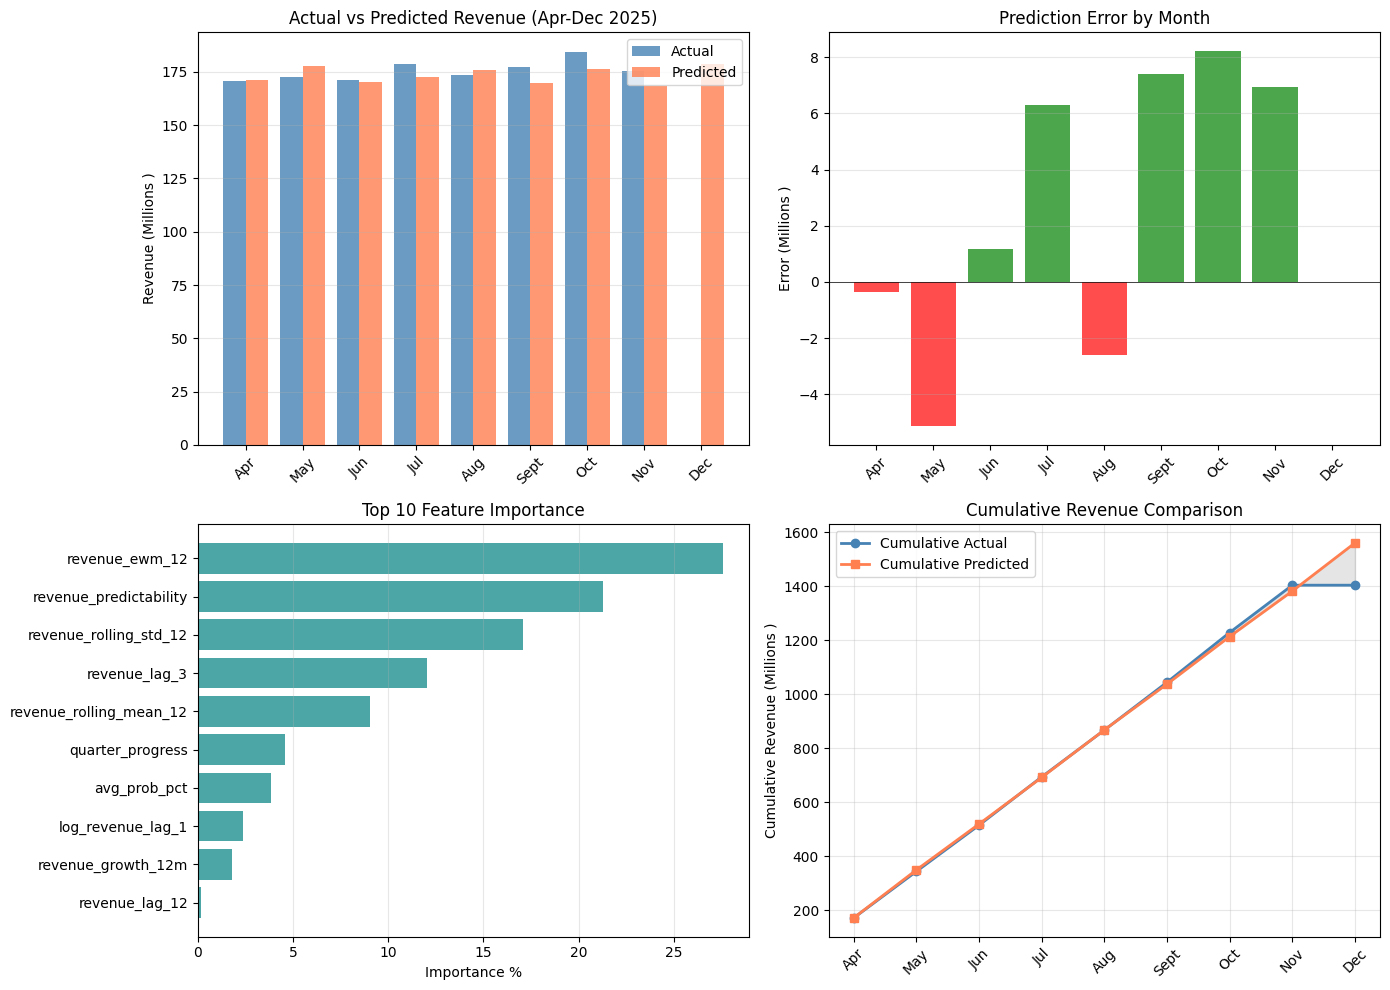

In [168]:
# Visualization
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted
ax1 = axes[0, 0]
months = test_data['month'].values
x_pos = range(len(months))
ax1.bar([x - 0.2 for x in x_pos], test_data['actual_revenue'].fillna(0) / 1e6,
        width=0.4, label='Actual', color='steelblue', alpha=0.8)
ax1.bar([x + 0.2 for x in x_pos], test_data['predicted_revenue'] / 1e6,
        width=0.4, label='Predicted', color='coral', alpha=0.8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(months, rotation=45)
ax1.set_ylabel('Revenue (Millions )')
ax1.set_title('Actual vs Predicted Revenue (Apr-Dec 2025)')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# 2. Error by month
ax2 = axes[0, 1]
errors = test_data['actual_revenue'] - test_data['predicted_revenue']
colors = ['green' if e >= 0 else 'red' for e in errors.fillna(0)]
ax2.bar(x_pos, errors.fillna(0) / 1e6, color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(months, rotation=45)
ax2.set_ylabel('Error (Millions )')
ax2.set_title('Prediction Error by Month')
ax2.grid(axis='y', alpha=0.3)

# 3. Feature importance
ax3 = axes[1, 0]
top_features = feature_importance.head(10)
ax3.barh(range(len(top_features)), top_features['Importance_%'].values, color='teal', alpha=0.7)
ax3.set_yticks(range(len(top_features)))
ax3.set_yticklabels(top_features['Feature'].values)
ax3.set_xlabel('Importance %')
ax3.set_title('Top 10 Feature Importance')
ax3.invert_yaxis()
ax3.grid(axis='x', alpha=0.3)

# 4. Cumulative comparison
ax4 = axes[1, 1]
cum_actual = test_data['actual_revenue'].fillna(0).cumsum() / 1e6
cum_pred = test_data['predicted_revenue'].cumsum() / 1e6
ax4.plot(x_pos, cum_actual, marker='o', label='Cumulative Actual', color='steelblue', linewidth=2)
ax4.plot(x_pos, cum_pred, marker='s', label='Cumulative Predicted', color='coral', linewidth=2)
ax4.fill_between(x_pos, cum_actual, cum_pred, alpha=0.2, color='gray')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(months, rotation=45)
ax4.set_ylabel('Cumulative Revenue (Millions )')
ax4.set_title('Cumulative Revenue Comparison')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

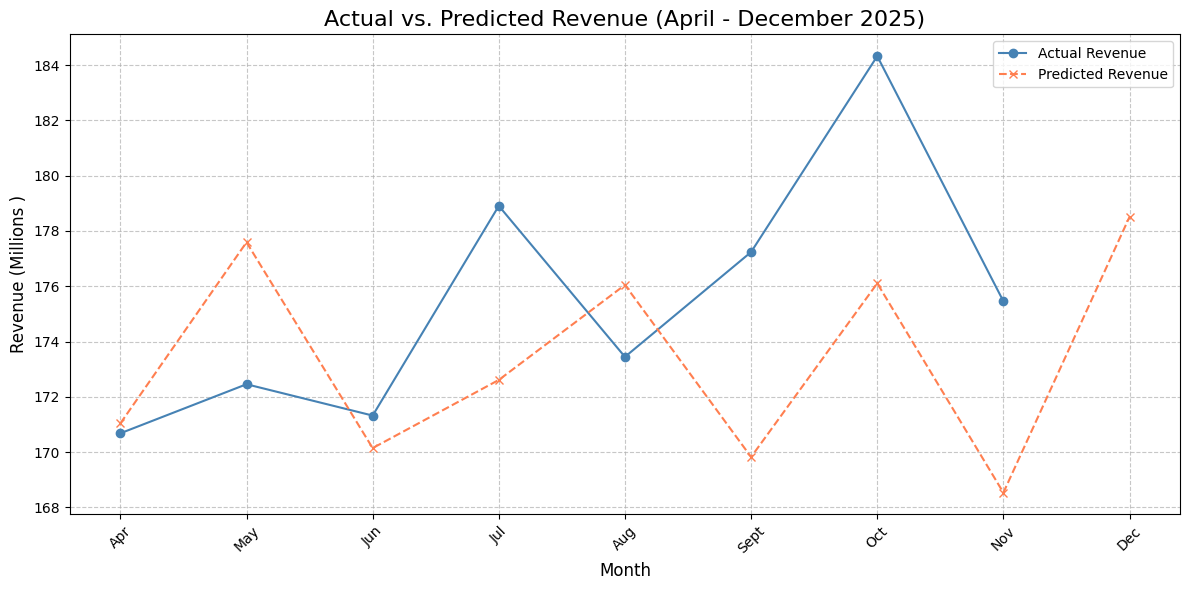

In [169]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_data['month'], test_data['actual_revenue'] / 1e6, marker='o', linestyle='-', color='steelblue', label='Actual Revenue')
plt.plot(test_data['month'], test_data['predicted_revenue'] / 1e6, marker='x', linestyle='--', color='coral', label='Predicted Revenue')

plt.title('Actual vs. Predicted Revenue (April - December 2025)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (Millions )', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()